# Report on Diabetes 

In [1]:
#First import the requisite packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm

After importing the requisite packages, let us load our data and merge it as needed. Additionally let us describe the data set in basic terms

In [26]:
#First let us load and merge our data into a single dataset
#Load our data into separate dataframes
ordinal_data = pd.read_csv('data_ordinal.csv')
cat_data = pd.read_csv('data_categorical.csv')
num_data = pd.read_csv('data_numeric.csv')

data_list = {'ordinal data':ordinal_data, 'categorical data':cat_data, 'numeric_data':num_data}

#merge our data into a single dataframe using the 'PERSONALID' variable
merged_data = pd.merge(ordinal_data, cat_data, on="PERSONID")
merged_data = pd.merge(merged_data, num_data, on="PERSONID")

#show head, tail, and shape to verify we loaded and merged data correctly
#print(merged_data.head)
print(merged_data.shape)

for df in data_list:
    print(f'{df} has {len(data_list[df].axes[0])} rows and {len(data_list[df].axes[1])} columns {len(data_list[df].axes[1])-1} exluding PERSONID \n')


(5000, 38)
ordinal data has 5000 rows and 11 columns 10 exluding PERSONID 

categorical data has 5000 rows and 23 columns 22 exluding PERSONID 

numeric_data has 5000 rows and 6 columns 5 exluding PERSONID 



It appears we have loaded the data correctly, with the number of rows being equal across all our datasets as well as our final dataset

However, upon inspection of the colunmns we have several duplicates of the 'DIABETE3' column let us begin the process of cleaning our data by dropping these repeat columns

In [3]:
#remove repeat diabetes columns
merged_data = merged_data.drop(['DIABETE3.1', 'DIABETE3_y', 'DIABETE3'], axis=1)

Before doing anymore data cleaning let us get an idea of some of our data variables using some visualizations of our data. Firstly, let's get a visualization of the Diabetes category as it will be our primary response variable. Secondly, let's get a visualization of some of the variables that could be primary indicators in our model in our model. Let's focus on variables that are health income adjacent for our initial analysis as well as demographic data to ensure our sample is reasonably representative and not demographically biased

Health Variables: 
- General Health: ordinal data so lets get a frequency chart 
- Asthma
- Mental Health: numeric data let us rescale our data so that no days with poor mental health is encoded as zero and values 'Not Sure', 'Blank', and 'Refused' are encoded as null
- Smoker 

Demographic Variables
- Sex
- Marital Status
- Race
- Income: Like mental health numeric data let us rescale our data so that 'Blank', and 'Refused' are encoded as null

Finally Diabetes, as this will be the response variable of our model. 


<function matplotlib.pyplot.show(close=None, block=None)>

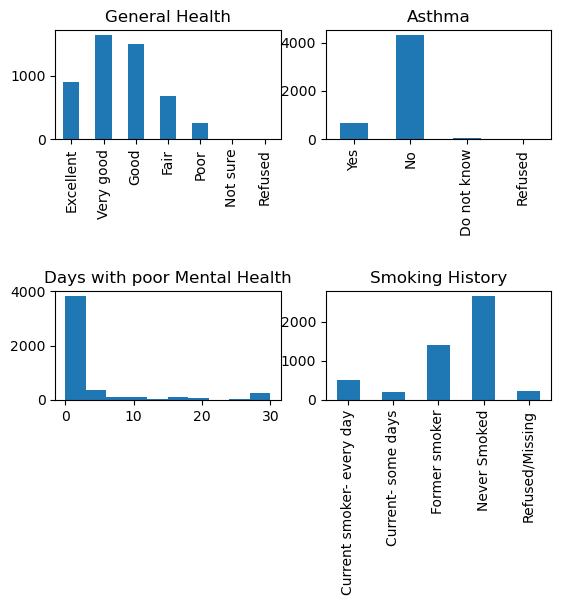

In [4]:

#rescale our data when needed

#Mental health
replace_values = {77 : np.nan, 88 : 0, r'^\s*$' : np.nan, 99 : np.nan }  
merged_data = merged_data.replace({"MENTHLTH": replace_values})

#Income
replace_values = {77 : np.nan, r'^\s*$' : np.nan, 99 : np.nan }  
merged_data = merged_data.replace({"INCOME2": replace_values})

#Diaetes
#Recode
replace_values = {4 : 1, 2:0, 3:0,}  
merged_data = merged_data.replace({'DIABETE3_x': replace_values})
#Drop missing/refused/don't know values
merged_data = merged_data.drop(merged_data[merged_data.DIABETE3_x.isin([7, 9, r'^\s*$'])].index)


# Create 2 by 4 figure of our selected variables with visualizations and summary stats when applicable
# Gen health plot

gen_h = merged_data['GENHLTH'].value_counts().sort_index()
gh_labels = ['Excellent', 'Very good', 'Good', 'Fair', 'Poor', 'Not sure', 'Refused']

plt.subplot(3, 2, 1)
gen_h.plot(kind='bar').set_xticklabels(gh_labels)
plt.title('General Health')

# Asthma plot

asth =  merged_data['ASTHMA3'].value_counts().sort_index()
ast_labels = ['Yes', 'No', 'Do not know', 'Refused']

plt.subplot(3, 2, 2)
asth.plot(kind='bar').set_xticklabels(ast_labels)
plt.title('Asthma')


# Mental health histogram

plt.subplot(3, 2, 5)
plt.hist(merged_data['MENTHLTH'], 10)
plt.title('Days with poor Mental Health')


# Smoker Plot
smo =  merged_data['_SMOKER3'].value_counts().sort_index()
smo_labels = ['Current smoker- every day', 'Current- some days', 'Former smoker', 'Never Smoked', 'Refused/Missing']

plt.subplot(3, 2, 6)
smo.plot(kind='bar').set_xticklabels(smo_labels)
plt.title('Smoking History')


plt.show






<function matplotlib.pyplot.show(close=None, block=None)>

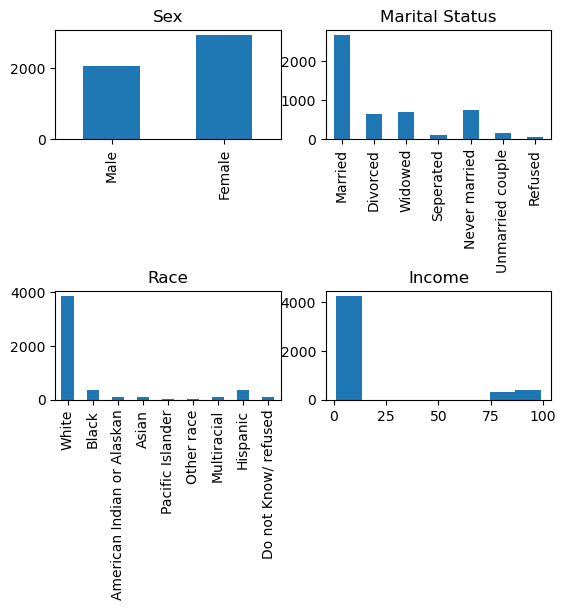

In [27]:
# Sex Plot
sex =  merged_data['SEX'].value_counts().sort_index()
sex_labels = ['Male', 'Female']

plt.subplot(3, 2, 1)
sex.plot(kind='bar').set_xticklabels(sex_labels)
plt.title('Sex')

# Marital Status Plot
ms =  merged_data['MARITAL'].value_counts().sort_index()
ms_labels = ['Married', 'Divorced', 'Widowed', 'Seperated', 'Never married', 'Unmarried couple', 'Refused']

plt.subplot(3, 2, 2)
ms.plot(kind='bar').set_xticklabels(ms_labels)
plt.title('Marital Status')

# Race Status Plot
race =  merged_data['_RACE'].value_counts().sort_index()
race_labels = ['White', 'Black', 'American Indian or Alaskan', 'Asian', 'Pacific Islander', 'Other race', 'Multiracial', 'Hispanic', 'Do not Know/ refused']

plt.subplot(3, 2, 5)
race.plot(kind='bar').set_xticklabels(race_labels)
plt.title('Race')

# Income histogram
plt.subplot(3, 2, 6)
plt.hist(merged_data['INCOME2'], 8)
plt.title('Income')


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

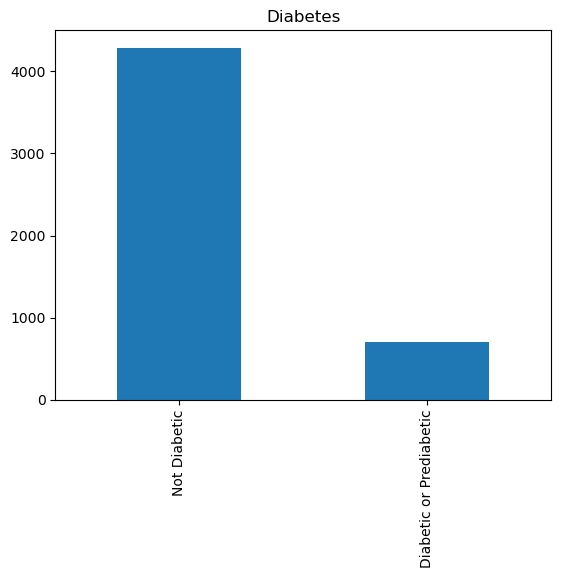

<Figure size 20x40 with 0 Axes>

In [25]:
#create plot for diabetes
diab = merged_data['DIABETE3_x'].value_counts().sort_index()
diab_labels = ['Not Diabetic','Diabetic or Prediabetic']

diab.plot(kind='bar').set_xticklabels(diab_labels)
plt.title('Diabetes')
plt.figure(figsize=(2, 4), dpi=10)
plt.show

### Data Cleaning

#### Categorical Data

Something we noticed is that blank and unsure responses can be recorded and regrouped together as they represent a very similar response. The advantage to this is reducing the number of categories reduces the chance of conflating variables or overfitting especially with these categories as they represent a small proportion of responses
We will only be doing this modification for variables that we select to use in the model as needed because the process is variable for each category.

#### Numeric Data

An issue that arises with numeric data is missing or refused values. Most prediction algorithms are not suited for missing values. To deal with this we can bin our data and group missing or refused data into a category together. Transforming the numeric data into categorical data. 
Income is already binned so we simply add a category for missing/refused encoded as 0.

Days with poor mental health has one extremely dominant category. So it makes sense to recode every other value as 1 creating a binary variable of 'Reported no days with poor mental health' as 'MENTHLTH2'. The reasoning for doing this is that we are concerned that sense relatively few people reported days with poor mental health leaving the granularity of number of days will lead to the model picking up a lot of noise, so creating a binary variable helps stem that risk.

#### Response Variable (Diabetes)

Let us recode this variable as a binary variable with Diabetics and Prediabetics coded as 1 and and non-diabetics and Gestational diabetics coded as 0. Additionally, let us drop non-responses entirely. If there is no response for our explained variable we should drop those observations from our model. 



In [6]:
#recode income
merged_data = merged_data.replace({'INCOME2': {np.nan:0}})
# create new binned variable 'MENTHLTH2'
merged_data['MENTHLTH2'] =  np.where(merged_data['MENTHLTH'] == 0, 0, 1)

#Asthma bin missing/recoded values with no as 'not reported'
merged_data = merged_data.drop(merged_data[merged_data.DIABETE3_x.isin([7, 9, r'^\s*$'])].index)
merged_data = merged_data.replace({'ASTHMA3': {7:2, 9:2, r'^\s*$':2}})

# group several refused/don't know values with missing values for several categorical variables
merged_data = merged_data.replace({'_RACE': {r'^\s*$':9}})
merged_data = merged_data.replace({'MARITAL': {r'^\s*$':9}})
merged_data = merged_data.replace({'_SMOKER3': {r'^\s*$':9}})
merged_data = merged_data.replace({'GENHLTH': {r'^\s*$':9, 7:9}})



### Building the Model

Let us build a model with the intention of determining the risk factors for Diabetes and Pre-Diabetes.

Let's build the model using a logistic regression framework. This method has several advantages

- It is easily interpretable to non-technical stakeholders, which will allow the model and its results to be utilized in the field unlike a black box methods like neural networks

- The output will be expressed as a probability of an individual being diabetic or prediabetic. This will allow stakeholders to understand the likelihood of an individual being prediabetic

- The model will return coefficients for each variable indicating whether that attribute is a risk factor for diabetes 


Our data is highly asymmetric, meaning we have many less diabetic and prediabetic people than not diabetic. Thus will We will iterate our model to optimize for the true positive rate (recall) minus the false positive rate


There are several logistic regression models to use let's use sklearn LogisticRegression

- This model allows us to use a machine learning framework to ensure our model has predictive ability, thus allowing stakeholders and practitioners to use our model to evaluate the risk of diabetes in new patients. This will be achieved by splitting our data into test and training sets, using the training set to fit the model and using the model to predict values in the test set. 

#### Metrics to assess performance

Predictive analytics - to access the predictive capability we will use the following metrics on the test set
- accuracy of the model on the test set ie number of correct predictions/total predictions
- recall (sensitivity or true positive rate): number of actual positive values the model detects/total actual positive values
- precision (specificity): number of actual positive values the model detects/total predicted positive values
- Comparing the performance on the test vs train sets: If the model performs much better on the training set than the test set  model is overfitted, the model is picking up on noise in the training set

Determining risk factors
- coefficient: magnitude/size of the coefficients will indicate the 'impact' of an attribute on the risk of diabetes


#### Variable selection
let us start with the variables we used for our data exploration giving a combination of both demographic and health risk factors for diabetes

We will be converting our data to categorical variables as dummy binary variables. The reason for this is even our 'numeric' data is binned into groups thus we need to treat them as categories.

In [7]:
# defining and splitting data
y_var = merged_data['DIABETE3_x']
X_vars = merged_data[['INCOME2','MENTHLTH2', 'ASTHMA3', '_RACE', 'MARITAL', '_SMOKER3', 'GENHLTH', 'SEX']]

#get dummies from our categorical data variables 
X_dum = pd.get_dummies(data = X_vars, columns=['INCOME2','MENTHLTH2', 'ASTHMA3', '_RACE', 'MARITAL', '_SMOKER3', 'GENHLTH', 'SEX'])
#split data into test and training sets using stratified random sampling
X_train, X_test, y_train, y_test = train_test_split(X_dum, y_var, test_size=0.2, stratify=y_var, random_state=42)

# define our initial model
logreg = LogisticRegression()
# Fit our model using our training data
logreg.fit(X_train, y_train)

LogisticRegression()

In [8]:
# use model to predict y values in the test set
y_pred = logreg.predict(X_test)

# output the performance metrics, confusion matrix, and classification report in order to evualate performance
confusion_matri = confusion_matrix(y_test, y_pred)
print(confusion_matri)
print(classification_report(y_test, y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


[[851   7]
 [136   5]]
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       858
         1.0       0.42      0.04      0.07       141

    accuracy                           0.86       999
   macro avg       0.64      0.51      0.49       999
weighted avg       0.80      0.86      0.80       999

Accuracy of logistic regression classifier on test set: 0.86


#### Interpreting the confusion matrix and classification report

From our analysis, we can show that our current classification is inadequate in a number of ways. An accuracy of 86% seems good on the surface. However, our recall is only 4% which is very low. This indicates the model is doing a woeful job of detecting individuals with diabetes or prediabetes. This is especially problematic in a medical context where it is more important to identify people with risk factors than not identify people without risk factors.

I believe that this is primarily a function of the asymmetric nature of our data, meaning we have many less diabetic and prediabetic people than not diabetic. To remedy this let's optimize our model for True Positive Rate (Sensitivity) - False Positive Rate by changing the classification threshold, the probability at which the model will classify an individual as Diabetic or Prediabetic, instead of the default threshold (0.5)


In [15]:
#define class to optimize model for TPR - FPR
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_tpr_minus_fpr(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_scores) 

        optimal_idx = np.argmax(tpr - fpr)

        return thresholds[optimal_idx], tpr[optimal_idx] - fpr[optimal_idx]

In [19]:
# Define new model with new class
lrt = LogisticRegressionWithThreshold()
# Train new model
lrt.fit(X_train, y_train)

# Optimize predictions for TRP - FPR in the training set and get threshold
threshold, optimal_tpr_minus_fpr = lrt.threshold_from_optimal_tpr_minus_fpr(X_train, y_train)

#Create new predicitions using optimized threshold
y_pred = lrt.predict(X_test, threshold) # test set
y_train_preds = lrt.predict(X_train, threshold) # training set
print(f'threshold: {threshold}, optimal true positive rate - false positive rate {optimal_tpr_minus_fpr}')

threshold: 0.12424448671549021, optimal true positive rate - false positive rate 0.434484110195854


In [17]:
# output the performance metrics, confusion matrix, and classification report in order to evualate performance on training set
confusion_matrixs = confusion_matrix(y_train, y_train_preds)
print('Performance analytics on training set')
print(confusion_matrixs)
print(classification_report(y_train, y_train_preds))

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lrt.score(X_train, y_train)))

# output the performance metrics, confusion matrix, and classification report in order to evualate performance on test set
confusion_matri = confusion_matrix(y_test, y_pred)
print('Performance analytics on test set')
print(confusion_matri)
print(classification_report(y_test, y_pred))

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lrt.score(X_test, y_test)))


Performance analytics on training set
[[2169 1263]
 [ 111  451]]
              precision    recall  f1-score   support

         0.0       0.95      0.63      0.76      3432
         1.0       0.26      0.80      0.40       562

    accuracy                           0.66      3994
   macro avg       0.61      0.72      0.58      3994
weighted avg       0.85      0.66      0.71      3994

Accuracy of logistic regression classifier on test set: 0.86
Performance analytics on test set
[[535 323]
 [ 39 102]]
              precision    recall  f1-score   support

         0.0       0.93      0.62      0.75       858
         1.0       0.24      0.72      0.36       141

    accuracy                           0.64       999
   macro avg       0.59      0.67      0.55       999
weighted avg       0.83      0.64      0.69       999

Accuracy of logistic regression classifier on test set: 0.86


After we optimize our regression for true positive rate - false positive rate, our model performs much better. Our recall (sensitivity) is much higher at 72% meaning our model detects diabetes and prediabetes in 72% of individuals who have it. It is notable that our precision is only 24%. In a medical context, this is okay because of the cost of a false positive being less than a false negative. 

Additionally, the accuracy of the model is still 86%, so the optimized model does not have less accuracy relative to the base model

Finally, the model performs reasonably well on the test set relative to the training set. The overall accuracy of the models is almost equivalent (86% and 86%) the precision/specificity of the model is also relatively similar at (24% vs 26%). However, sensitivity on the test set is less than that on the training set (72% vs 80%). This is somewhat problematic as sensitivity is perhaps the most important performance metric. We can say that our model is slightly overfitted, but still has strong predictive capacity.

#### Interpreting the model and finding risk factors for diabetes

In [28]:
# define class to calculate p-values the models
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(abs(np.diag(vcov)))
    t =  coefs/se  
    p = 1- ((1 - norm.cdf(abs(t))) * 2)
    p = np.delete(p, 0)
    return p

pvals = logit_pvalue(logreg, X_train)
# Create dataframe with variables, coeficients, p-values, and the statistical significance of the coeffiecents

model_output = pd.DataFrame()
model_output['Variables']= X_dum.columns
model_output['Coefficients']= lrt.coef_[0]

model_output

,Variables,Coefficients
0,INCOME2_0.0,0.073524
1,INCOME2_1.0,-0.141542
2,INCOME2_2.0,0.186753
3,INCOME2_3.0,-0.014124
4,INCOME2_4.0,0.182426
5,INCOME2_5.0,0.088385
6,INCOME2_6.0,0.281969
7,INCOME2_7.0,-0.356994
8,INCOME2_8.0,-0.302581
9,MENTHLTH2_0,0.137914


From our coefficients we can discern the 'impact' of each variable on the model. The greater the coefficient magnitude (size), the more impactful the model suggests the variable is. Positive coefficients indicate greater risk of diabetes and negative coefficients indicate less risk of diabetes.

Income: The model suggests higher income people are at decreased risk of diabetes

Mental Health: The model suggests those who reported days with poor mental health are less at likely to have diabetes. I believe this is could be an instance of confounding variables

Race: The coefficients suggest Black/African Americans and Native American/Alaskans are at a greater risk for diabetes. Also note, that those who refused seem to be at a greater risk of diabetes

Asthma: Asthma is also a risk factor for diabetes

Smoking: The model suggests current smokers were at less of a risk for diabetes, which runs counter to what we expect. However, former smokers are at a greater risk for diabetes. 

Marital Status: Marital status showed us an interesting relationship. Married and Widowed people showed the greatest risk, followed by divorced or separated people, then never married and people in unmarried relationships. I suspect this is primarily a function of age. If we iterated the model, I would examine the relationship of marital status and age as well as age and diabetes. 

General Health: The coefficients suggest those who reported better general health were at decreased risk of diabetes

Sex: The coefficients suggest males are at slightly greater risk for diabetes



#### What the model tells us, limits, and steps to improve the model in the future

Because we tested our model on a testing set we know the model has good predictive ability. The best use case would be for a practitioner to use our model to determine the probability of a patient having diabetes. Additionally, the model did discern potential risk factors that stakeholders could apply in the field.

However, the limitation of our model is the rigorousness in which we know the identified risk factors are actual risk factors for diabetes. I believe there is evidence that the model is confounding risk factors. In order to have more clarity on the risk factors, next steps would be to run a significance test (Wald test and or t test) on the variables to determine if the risk factors are statistically significant.

Other steps with a greater time scope would be to iterate the model with new combinations of variables including new variables, removing statistically insignificant variables. I'm specifically interested in adding age and removing marital status. This process would lead to a better performing model and hopefully one that is more explanatory in nature.
